### Inside Deep Learning - Chap1 - Exercises - ipark

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
import torch

> 1. Write a series of for loops that compute the average value in torch_tensor3d. 

In [3]:
import torch
torch_tensor3d = torch.tensor([#<--4 x 
                                [#<-- 2 x 
                                  [#<-- 3
                                   1,  2,  3],
                                  [4,  5,  6],],
                                [ [7,  8,  9],
                                  [10, 11, 12],],
                                [ [13, 14, 15],
                                  [16, 17, 18],],
                                [ [19, 20, 21],
                                  [22, 23, 24],]
                               ])
torch_tensor3d.size() # torch.Size([4, 2, 3])
channels, rows, cols = torch_tensor3d.size()
#print(channels, rows, cols)
nums, sums = 0, 0
for ch in range(channels):
    for row in range(rows):
        for col in range(cols):
            nums += 1
            sums += torch_tensor3d[ch][row][col]
avg = sums/nums
print(avg.item())

12.5


> 2. Write code that indexes into torch_tensor3d and prints out the value 13.

In [4]:
channel, row, col = 2, 0, 0
val = torch_tensor3d[channel][row][col]
print(val.item())

13


> 3. For every power of 2 up to $2^{11}$, create a random matrix X ∈ ℝ$2^{11},2^{11}$ (i.e., X.shape should give ($2^i$, $2^i$)). Time how long it takes to compute XX (i.e., X @ X) on a CPU and on a GPU, and plot the speedup. For what matrix sizes is the CPU faster than the GPU?

In [5]:
import timeit
timeD = dict()
for hw in ["cpu", "cuda"]:
    device = torch.device(hw)
    time_list = list()
    for pow in range(11+1):
        x = torch.rand(2**pow, 2**pow)
        x = x.to(device)
        time = timeit.timeit("x@x", globals=globals(), number=100)
        time_list.append(time)
        #print(f'device={device}, pow={pow}, time={time}')
    timeD[device.type] = time_list
print(timeD)

{'cpu': [0.0018407570023555309, 0.0011775810016843025, 0.000232939997658832, 0.0002531749996705912, 0.0002635749988257885, 0.00039468500108341686, 0.013584402000560658, 0.010593459999654442, 0.025241965002351208, 0.07109507800123538, 0.18803466700046556, 1.43711002100099], 'cuda': [0.015947888998198323, 0.0025579270004527643, 0.000338475001626648, 0.0003276700008427724, 0.00032479999936185777, 0.0016901239978324156, 0.00033941599758691154, 0.0006518179980048444, 0.004377639001177158, 0.000373973001842387, 0.0004749370018544141, 0.0014595020002161618]}


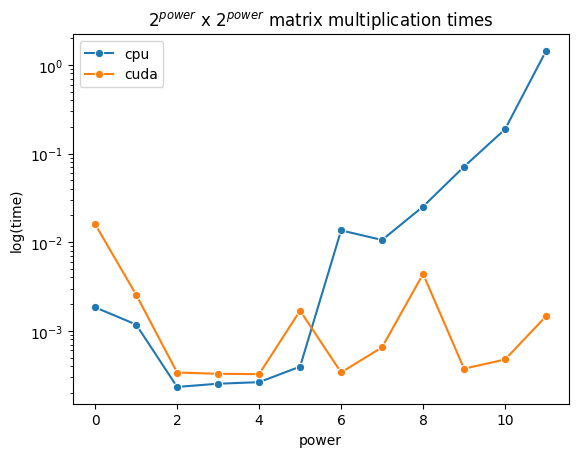

In [6]:
s=sns.lineplot(data=timeD, dashes=0, markers=['o', 'o']);
s.set(yscale='log', xlabel='power',  ylabel='log(time)', title='$2^{power}$ x $2^{power}$ matrix multiplication times');



> 4. We used PyTorch to find the numeric solution to $f(x) = (x−2)^2$. Write code that finds the solution to $$f(x) = sin(x − 2) · (x + 2)^2 + √|cos(x)|. $$ What answer do you get?

In [7]:
def f(x):
    return torch.sin(x-2.0) * torch.pow((x+2.0),2) + torch.sqrt(torch.abs(torch.cos(x)))


x_param_list, x_grad_list = list(), list()

x_param = torch.nn.Parameter(torch.tensor([-2.5]), requires_grad=True)
optimizer = torch.optim.SGD([x_param], lr=0.1)
for epoch in range(100):
    optimizer.zero_grad() #x.grad.zero_()
    loss_incurred  = f(x_param)
    loss_incurred.backward()
    optimizer.step() #x.data -= eta * x.grad
    x_param_list.append(x_param.data.item())
    x_grad_list.append(x_param.grad.item())
print(x_param.data)


tensor([1.0635])


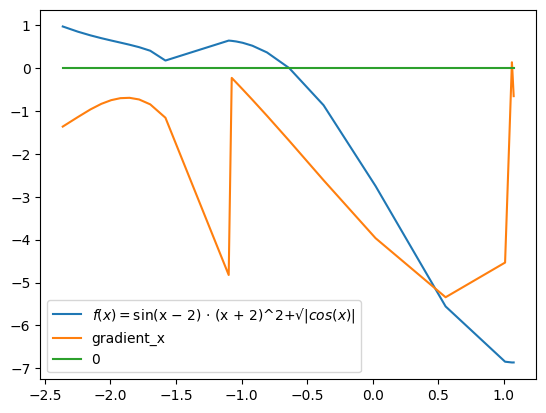

In [8]:

x_axis_vals = np.array(x_param_list) #np.linspace(-2,2,100) 
y_axis_vals = f(torch.tensor(x_axis_vals)).numpy()
x_grad_vals = np.array(x_grad_list)

sns.lineplot(x=x_axis_vals, y=y_axis_vals, label='$f(x) = $sin(x − 2) · (x + 2)^2$ + √|cos(x)|$');
sns.lineplot(x=x_axis_vals, y=x_grad_vals, label="gradient_x");
sns.lineplot(x=x_axis_vals, y=[0.0]*len(x_axis_vals), label="0");


> 5. Write a new function that takes two inputs, x and y, where $$f(x, y) = exp (sin(x)^2)/(x−y)^2 + (x−y)^2$$ Use an Optimizer with initial parameter values of x = 0.2 and y = 10.  What do they converge to?

In [9]:
def f(x, y):
    return torch.exp(torch.pow(torch.sin(x),2.0)) / torch.pow(x-y,2) + torch.pow(x-y,2)

x_param_list, x_grad_list = list(), list()
x_param = torch.nn.Parameter(torch.tensor([0.2]), requires_grad=True)

y_param_list, y_grad_list = list(), list()
y_param = torch.nn.Parameter(torch.tensor([10.0]), requires_grad=True)

optimizer = torch.optim.SGD([x_param, y_param], lr=0.1)
for epoch in range(100):
    optimizer.zero_grad() #x.grad.zero_()
    loss_incurred  = f(x_param, y_param)
    loss_incurred.backward()
    optimizer.step() #x.data -= eta * x.grad
    x_param_list.append(x_param.data.item())
    x_grad_list.append(x_param.grad.item())
    y_param_list.append(y_param.data.item())
    y_grad_list.append(y_param.grad.item())
print(x_param.data, y_param.data)


tensor([3.1419]) tensor([4.1419])


> 6. Create a function libsvm2Dataset that takes a path to a libsvm dataset file and create a new dataset object. Check that it is the correct length and that each row has the expected number of features.
(see https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/ for many that you can download) 

In [10]:
from torch.utils.data import Dataset
from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto', as_frame=False)
                                                             ##############################
print(X.shape)
class SimpleDataset(Dataset):
        
    def __init__(self, X, y):
        super(SimpleDataset, self).__init__()
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        #This "work" could have gone in the constructor, but you should get into 
        inputs = torch.tensor(self.X[index,:], dtype=torch.float32)
        targets = torch.tensor(int(self.y[index]), dtype=torch.int64)
        return inputs, targets 

    def __len__(self):
        return self.X.shape[0]
#Now we can make a PyTorch dataset 
dataset = SimpleDataset(X, y)

print("Length: ", len(dataset))
example, label = dataset[0]
print("Features: ", example.shape) #Will return 784
print("Label of index 0: ", label)


(70000, 784)
Length:  70000
Features:  torch.Size([784])
Label of index 0:  tensor(5)


In [11]:
"""
usps
Source: [JJH94a]
# of classes: 10
# of data: 7,291 / 2,007 (testing)
# of features: 256
Files:
usps.bz2
usps.t.bz2 (testing)

"""
import os.path

class libsvm2Dataset:
    def __init__(self, data_path):
        self.data_path= data_path
        df = pd.read_csv(data_path, sep=" \d+:",  header=None, engine='python')
        self.y = df.iloc[:, 0].to_numpy()
        self.X = df.iloc[:, 1:].to_numpy()
        self.classes = len(df.iloc[:, 0].unique())
        
    def __getitem__(self, index):
        inputs = torch.tensor(self.X[index,:], dtype=torch.float32)
        targets = torch.tensor(int(self.y[index]), dtype=torch.int64)
        return inputs, targets 

    def __len__(self):
        return self.X.shape[0]

In [12]:
train_data_path = "data/USPS/usps"
test_data_path = "data/USPS/usps.t"
trainset = libsvm2Dataset(train_data_path)
testset = libsvm2Dataset(test_data_path)

# of classes: 10
# of data: 7,291 / 2,007 (testing)
# of features: 256
print(f'data_path: {train_data_path}')
print(f'# of classes: {trainset.classes}')
print(f'# of data: {len(trainset)}:{len(testset)}')
print(f'# of features: {len(trainset[10][0])}')


data_path: data/USPS/usps
# of classes: 10
# of data: 7291:2007
# of features: 256


> 7. Challenging: Use NumPy’s memmap functionality to write the MNIST dataset to disk. Then create a MemmapedSimpleDataset that takes the mem-mapped file as input, reading the matrix from disk to create PyTorch tensors in the __getitem__ method. Why do you think this would be useful?

In [17]:
from torch.utils.data import Dataset
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
original_Xshape, original_yshape = X.shape, y.shape

In [18]:
import numpy as np
# Write the array to disk using memmap
memmap_X = 'memmap_X.dat'
memmap_y = 'memmap_y.dat'

fpX = np.memmap(memmap_X, dtype='float32', mode='w+', shape=original_Xshape)
fpy = np.memmap(memmap_y, dtype='int64', mode='w+', shape=original_yshape)

# write to memmap
fpX[:] = X[:]
fpy[:] = y[:]
# flush
fpX.flush()
fpy.flush()

# Read the array from disk
newfpX = np.memmap(memmap_X, dtype='float32', mode='r', shape=original_Xshape)
newfpy = np.memmap(memmap_y, dtype='int64', mode='r', shape=original_yshape)

print(newfpX[5], newfpy[5])
newfpX.flush()
newfpy.flush()


[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  13.  25. 100. 122.   7.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  33.
 151. 208. 252. 252. 252. 146.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 

In [23]:
"""
takes the mem-mapped file as input, 
reading the matrix from disk to create PyTorch tensors in the getitem method.
Why do you think this would be useful?
"""
class MemmapedSimpleDataset:
    def __init__(self, memmap_X, memmap_y, original_Xshape, original_yshape):
        self.X = np.memmap(memmap_X, dtype='float32', mode='r', shape=original_Xshape)
        self.y = np.memmap(memmap_y, dtype='int64', mode='r', shape=original_yshape)

    def __getitem__(self, index):
        inputs = torch.from_numpy(np.asarray(self.X[index]))
        targets = torch.from_numpy(np.asarray(self.y[index]))
        return inputs, targets 

    def __len__(self):
        return self.X.shape[0]
    
    


In [24]:
memmap_X = 'memmap_X.dat'
memmap_y = 'memmap_y.dat'
mem_dataset = MemmapedSimpleDataset(memmap_X, memmap_y, original_Xshape, original_yshape)
print(f'# of data: {len(mem_dataset)}')
print(f'# of features: {len(mem_dataset[5])}')

# of data: 70000
# of features: 2
